In [1]:
from lib.greedy_circs import *
import qiskit 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister


import numpy as np
from lib.dvr1d import *
from lib.utils import *
from lib.vqe import DVR_VQE
from lib.pot_gen import get_pot_cr2

# from lib.local_utils import base_dir, scratch_dir

mol_params = cr2_params
spin = 13
mol_params['name'] += f'_{spin}'

# 16 points
params16 = [5.2, 9]

pot, lims = get_pot_cr2(spin)
dvr_vqe = DVR_VQE(mol_params, pot)
entangler_map = [[0, 1], [1, 2], [2, 3], [0, 4]]
def gen_ansatz_op(mol_params, spin, params16, entangler_map):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.circuit.library import TwoLocal
    from qiskit.circuit.library import ECRGate, SXGate
    mol_params = mol_params.copy()  # create a copy to avoid changing the original mol_params
    mol_params['name'] += f'_{spin}'
    dvr_options = {
            'type': '1d',
            'box_lims': (params16[0], params16[1]),
            'dx': (params16[1] - params16[0]) / 32,
            'count': 32,
        }
    
     
    # obtain the potential for a CR2 at certain radii
    pot, lims = get_pot_cr2(spin)

    # perform a dvr vqe to obtain the hamiltonian
    dvr_vqe = DVR_VQE(mol_params, pot)
    h_dvr = dvr_vqe.get_h_dvr(dvr_options, J=0) * hartree

     # Perform a Pauli Decomposition to get the Hamiltonian and get a composition.
    h_dvr_p0 = SparsePauliOp.from_operator(h_dvr)
    print(h_dvr_p0.coeffs)
    num_qubits = int(np.log2(h_dvr.shape[0]))
    ecr = ECRGate(label='ecr', duration=1, unit='ms').definition
    sx = SXGate(label='sx').definition
    a = TwoLocal(num_qubits, rotation_blocks=['ry'], entanglement_blocks=['cx'], entanglement=entangler_map, reps=3, insert_barriers=False).decompose()
    a = transpile(a, basis_gates=['id', 'rz', 'x', 'sx', 'ecr'])
    return h_dvr, h_dvr_p0, a


h_dvr, h_dvr_p0, a = gen_ansatz_op(mol_params, spin, params16, entangler_map)

print(h_dvr_p0)

ModuleNotFoundError: No module named 'utils'

In [29]:
a2 = QuantumCircuit(2)
a2.cx(0, 1)
a2.measure_all()

In [26]:
a3 = QuantumCircuit(2)
a3.ecr(0, 1)
a3.measure_all()

In [5]:
def Run_VQE(a, optimizers, params, estimator, operator):
    from qiskit_algorithms.minimum_eigensolvers import VQE
    """ This is the function that runs the VQE."""
    repeat = 3
    params = None
    # params = np.array([float(i) for i in result.optimal_parameters.values()])
    converge_cnts1 = np.empty([len(optimizers)], dtype=object)
    converge_vals1 = np.empty([len(optimizers)], dtype=object)

    for i, optimizer in enumerate(optimizers):
        print('Optimizer: {}        '.format(type(optimizer).__name__))
        # algorithm_globals.random_seed = 42

        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            print(f'\r{eval_count}, {mean}', end='')
        best_res1 = None
            
        for j in range(repeat):
            counts = []
            values = []
            vqe = VQE(estimator=estimator, ansatz=a, optimizer=optimizer, initial_point=params, callback=store_intermediate_result)
            results = vqe.compute_minimum_eigenvalue(operator=operator)
            print()
            if (best_res1 is None) or (values[-1] <= best_res1):
                best_res1 = values[-1]
                converge_cnts1[i] = np.asarray(counts)
                converge_vals1[i] = np.asarray(values)
        print('\nOptimization complete ') 
    return converge_cnts1, converge_vals1, results


In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
from qiskit.tools.visualization import plot_histogram

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='pinq-quebec-hub/qai-quantum-algo/default',
    token='50e4f60f02cd247a763d93cbeb949668b4383e6df68ba8a7b4c97b35be7d9cf41f83566cb249b7619d46f081d8349d911392a9d12def4088966310b9168a7f10'
)


backend = service.backend('ibm_quebec')

options = Options(optimization_level=2, resilience_level=2)
jobs = []
cnot = transpile(a2, backend)
result = backend.run(cnot).result()
count = result.get_counts(cnot)
execution_time = result.time_taken 
plot_histogram(count, title='Bell-State counts')
print(execution_time)

  

KeyboardInterrupt: 

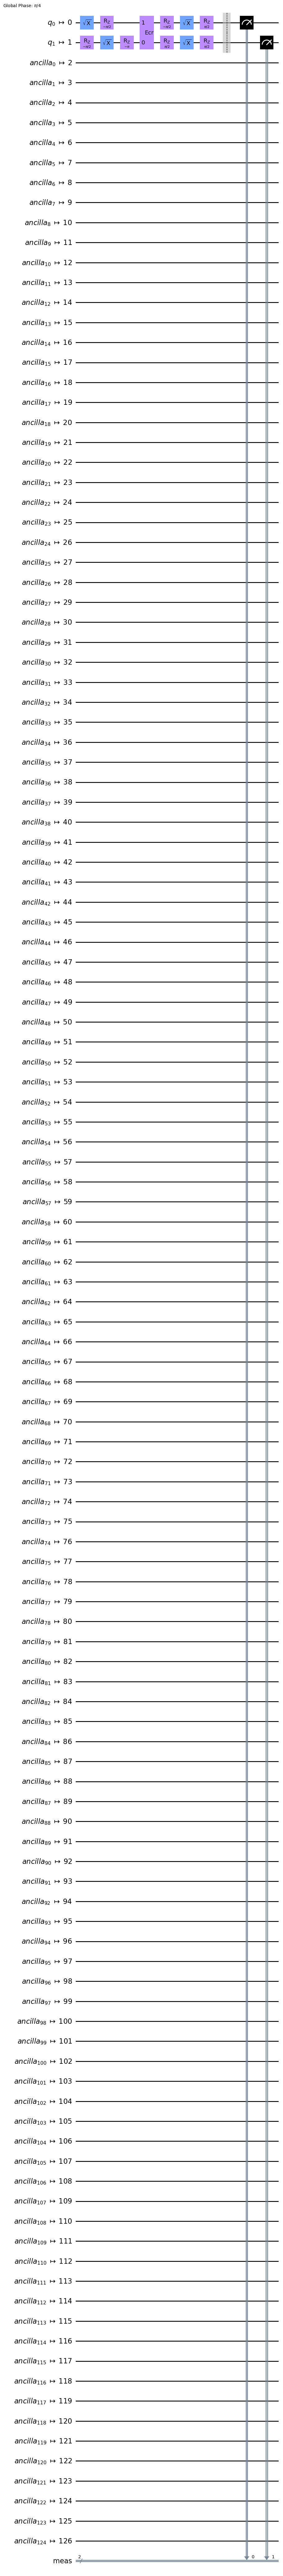

In [32]:
cnot.draw(output='mpl')

In [31]:
options = Options(optimization_level=2, resilience_level=2)
ecr = transpile(a3, backend)
result = backend.run(ecr).result()
count = result.get_counts(ecr)
execution_time = result.time_taken 
plot_histogram(count, title='Bell-State counts')
print(execution_time)


2.098606178


In [95]:
from qiskit_ibm_runtime import Batch 
from qiskit.algorithms.optimizers import SPSA, COBYLA, NELDER_MEAD, GSLS
optimizer = [[SPSA(maxiter=1000), COBYLA(maxiter=1000), NELDER_MEAD(maxiter=1000), GSLS(maxiter=10000)]]
jobs = []
with Batch(service=service, backend=backend) as batch:
    estimator = Estimator(batch)
    for opt in optimizer:
        job = Run_VQE(a, opt, None, estimator, h_dvr_p0)
        print(job)
        jobs.append(job)
        

Optimizer: SPSA        
1, 1656.417549186226

KeyboardInterrupt: 

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='pinq-quebec-hub/qai-quantum-algo/default',
    token='50e4f60f02cd247a763d93cbeb949668b4383e6df68ba8a7b4c97b35be7d9cf41f83566cb249b7619d46f081d8349d911392a9d12def4088966310b9168a7f10'
)

jobs = service.jobs(limit=800, backend_name='ibm_quebec', session_id="cq1yp3rd7we0008hg8h0")
results = []
counts = []
for job in jobs:
    result = job.result()
    results.append(result)
    

In [42]:
from qiskit.circuit.library import TwoLocal
a = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks=['cx'], entanglement='linear', reps=3, insert_barriers=False).decompose()
kc = transpile(a, basis_gates=['id', 'rz', 'x', 'sx', 'ecr'])
kc.draw(style="iqp")
result_kc= backend.run(kc).result()
count_kc = result_kc.get_counts(kc)
execution_time_kc= result_kc.time_taken 
print(execution_time_kc)

runtime_job._start_websocket_client:WARNING:2024-01-23 03:01:49,532: An error occurred while streaming results from the server for job cpqs2wksp83g008ybawg:
Traceback (most recent call last):
  File "/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-packages/qiskit_ibm_runtime/runtime_job.py", line 546, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-packages/qiskit_ibm_provider/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-packages/qiskit_ibm_provider/api/clients/base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_provider.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/Users/ethanelliotrajkumar/anaconda3/lib/python3.11/site-pa

KeyboardInterrupt: 